In [ ]:
!pip install tensorflow==2.3.0

In [ ]:
!pip install SimpleITK

     |████████████████████████████████| 44.9MB 69kB/s 


In [ ]:
#import libraries
import os
import numpy as np
import skimage.io as io
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import glob
import glob2 
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Entire pipeline function for segmenting the tumor

In [ ]:
def function_(patient_dirs):
  """
  This function takes patients  image paths and performs the following operation:

  1.Bias Field correction
  2.pre-processing of corrected image modalities
  3.create slices of the pre-processed images
  4.predicts the tumor regions in slices using trained best model-Cannet with vgg as backbone

  Function parameters:
  image_path: patients MRI volumes path
  
  Returns:
  X:patients image
  predictions:predicted label
  
  """
  def bias_field_correction(image_p):
    """
    Before giving to the pre-processing stage the raw data and is bias corrected as this 
    bias signal is a very low frequency signal and smooth which will corrupt the mri image which will be difficult for 
    image segmentation algorithms to process the images

    Function Parameters:
    --------------------
    image_path: path of the image 
    
    Returns:

    img_c:corrected image

    """
    img = sitk.ReadImage(image_p)
    img_mask = sitk.OtsuThreshold(img)
    img = sitk.Cast(img, sitk.sitkFloat32)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    img_c = corrector.Execute(img, img_mask)
    corrected_image=sitk.GetArrayFromImage(img_c)
    
    
    return corrected_image
  flair=[]
  t1=[]
  t1ce=[]
  t2=[]
  mask=[]

  for i in patient_dirs:
    modalities=os.listdir(i)
    for seq in modalities:
        if 'flair' in seq:
            c=bias_field_correction(i+'/'+seq)
            flair.append(c)
        if ('t1' in seq) and ('t1ce' not in seq):
            c=bias_field_correction(i+'/'+seq)
            t1.append(c)
        if ('t1ce' in seq):
            c=bias_field_correction(i+'/'+seq)
            t1ce.append(c)
        if ('seg' in seq):
            c=bias_field_correction(i+'/'+seq)
            mask.append(c)


  def preprocessing(image_volume):
    """
    This function is used to preprocess the given corrected image volume of lgg ang hgg
    1.perform standardization for non zero pixels in array
    2.clipping image to range [-5,5]
    3.Normalizing non brain region pixels 

    Function Parameters:
    Image_volume: Input image volume of lgg or hgg

    Returns:
    scaled_image:pre-processed image volume
    """
    
    #compute std dev and mean for non zero elements in array
    #standardization
    std_dev=np.std(image_volume[np.nonzero(image_volume)])
    mean=np.mean(image_volume[np.nonzero(image_volume)])
    stdzn=(image_volume-mean)/std_dev
    
    #clipping the image to range [-5,5]
    clip_=np.clip(stdzn,-5,5)
    #to set non brain region to 0 before passing it to normalization
    mask_=(image_volume!=0)
    
    #after rescaling,multiply the rescaled image with mask to get image which has non brain region as 0

    rescaled_image=(clip_ - clip_.min()) / (clip_.max() - clip_.min())
    
    rescaled_image=mask_*rescaled_image
    
    return rescaled_image

  pre_flair=[]
  pre_t1=[]
  pre_t1ce=[]
  for a,b,c in zip(flair,t1,t1ce):
    pre_flair.append(preprocessing(a))
    pre_t1.append(preprocessing(b))
    pre_t1ce.append(preprocessing(c))
  
  
  def create_slices(grade_type,collected=False,b=[]):

    """
    This function create slices of an image volume
    Function parameters:
    ---------------------
     grade_type: list of image volumes of type of grade
     collected: False:collects the slice indexes of image volumes which are useful to take same type of slices of all the sequences
     eg:if index 5  slice of a image flair volume is collected first then its same index is given to t1 so to get that particular slice of the same image volume
     likewise done for all slices and all image volumes of patients
     b=[]:It is empty when no slice index is taken

     Returns:
     --------
     b:slice indexes
     slices:slices of given modalities
    
    """
    
    count=0
    slices=[]
    for image in grade_type:
        #print(image.shape[0])
        
        if (collected == False):
            v=[]
            
            for slice_ in range(image.shape[0]):
                if (slice_%2==1) and (slice_<141):
                    if (np.count_nonzero(image[slice_])>=7359): 
                        v.append(slice_)
                        slices.append(image[slice_].astype('float32'))
               
            b.append(v)
        
        else:
            
            while(count<len(b)):
            
           # image_volume=io.imread("new_data/"+modality+"_"+grade+"/"+image, plugin='simpleitk')
        
                
                for slice_other_modality in b[count]:
                    #print(slice_other_modality)
                    #break
                    val=image[slice_other_modality]

                    slices.append(val.astype('float32'))
                count+=1
                break
                
    return b,slices
    
  indexes_f,flair_slices=create_slices(pre_flair,collected=False,b=[])
  indexes_t1,t1_slices=create_slices(pre_t1,collected=True,b=indexes_f)
  indexes_t1ce,t1ce_slices=create_slices(pre_t1ce,collected=True,b=indexes_f)
  indexes_seg,mask_slices=create_slices(mask,collected=True,b=indexes_f)



#min no.of non zero pixels
  min_thresh=10005

  l=[]
  for index,Slice in enumerate(flair_slices):
    if np.count_nonzero(Slice)>=min_thresh:
        l.append(index)
  Data_flair=[]
  Data_t1=[]
  Data_t1ce=[]
  Data_t2=[]
  Data_mask=[]

  for i in l:
    Data_flair.append(flair_slices[i])
    Data_t1.append(t1_slices[i])
    Data_t1ce.append(t1ce_slices[i])
    Data_t2.append(t2_slices[i])
    Data_mask.append(mask_slices[i])

  
  
    # classes for data loading and preprocessing
    #to create masks for each slice
  classes=[0,1,2,4]
  X=[]
  y=[]
  for a,b,c,d in zip(Data_flair,Data_t1,Data_t1ce,Data_mask):
    a1=a[8:232,8:232]
    b1=b[8:232,8:232]
    c1=c[8:232,8:232]
    d1=d[8:232,8:232]
    image=np.stack((a1,b1,c1),axis=-1)
    masks = [(d1 == v) for v in classes]
    mask = np.stack(masks, axis=-1).astype('float')
    X.append(image)
    y.append(mask)
 #Loading pretrained cannet model with vgg backbone without augmentation for predictions
  model_canet=load_model("/content/drive/My Drive/dl_cannet/cannet_weights.h5")
  predictions=model_canet.predict(np.array(X))

  return X,predictions



In [ ]:
#patient modalities
patient_dirs=['/content/Brats18_TCIA09_255_1','/content/Brats18_TCIA13_650_1','/content/Brats18_TCIA13_653_1','/content/Brats18_TCIA13_654_1']

In [ ]:
X,predictions=function_(patient_dirs)

## Segmentation of Tumor for 5 patients -Using CANNET Architecture with VGG16 as backbone without Augmentation techniques


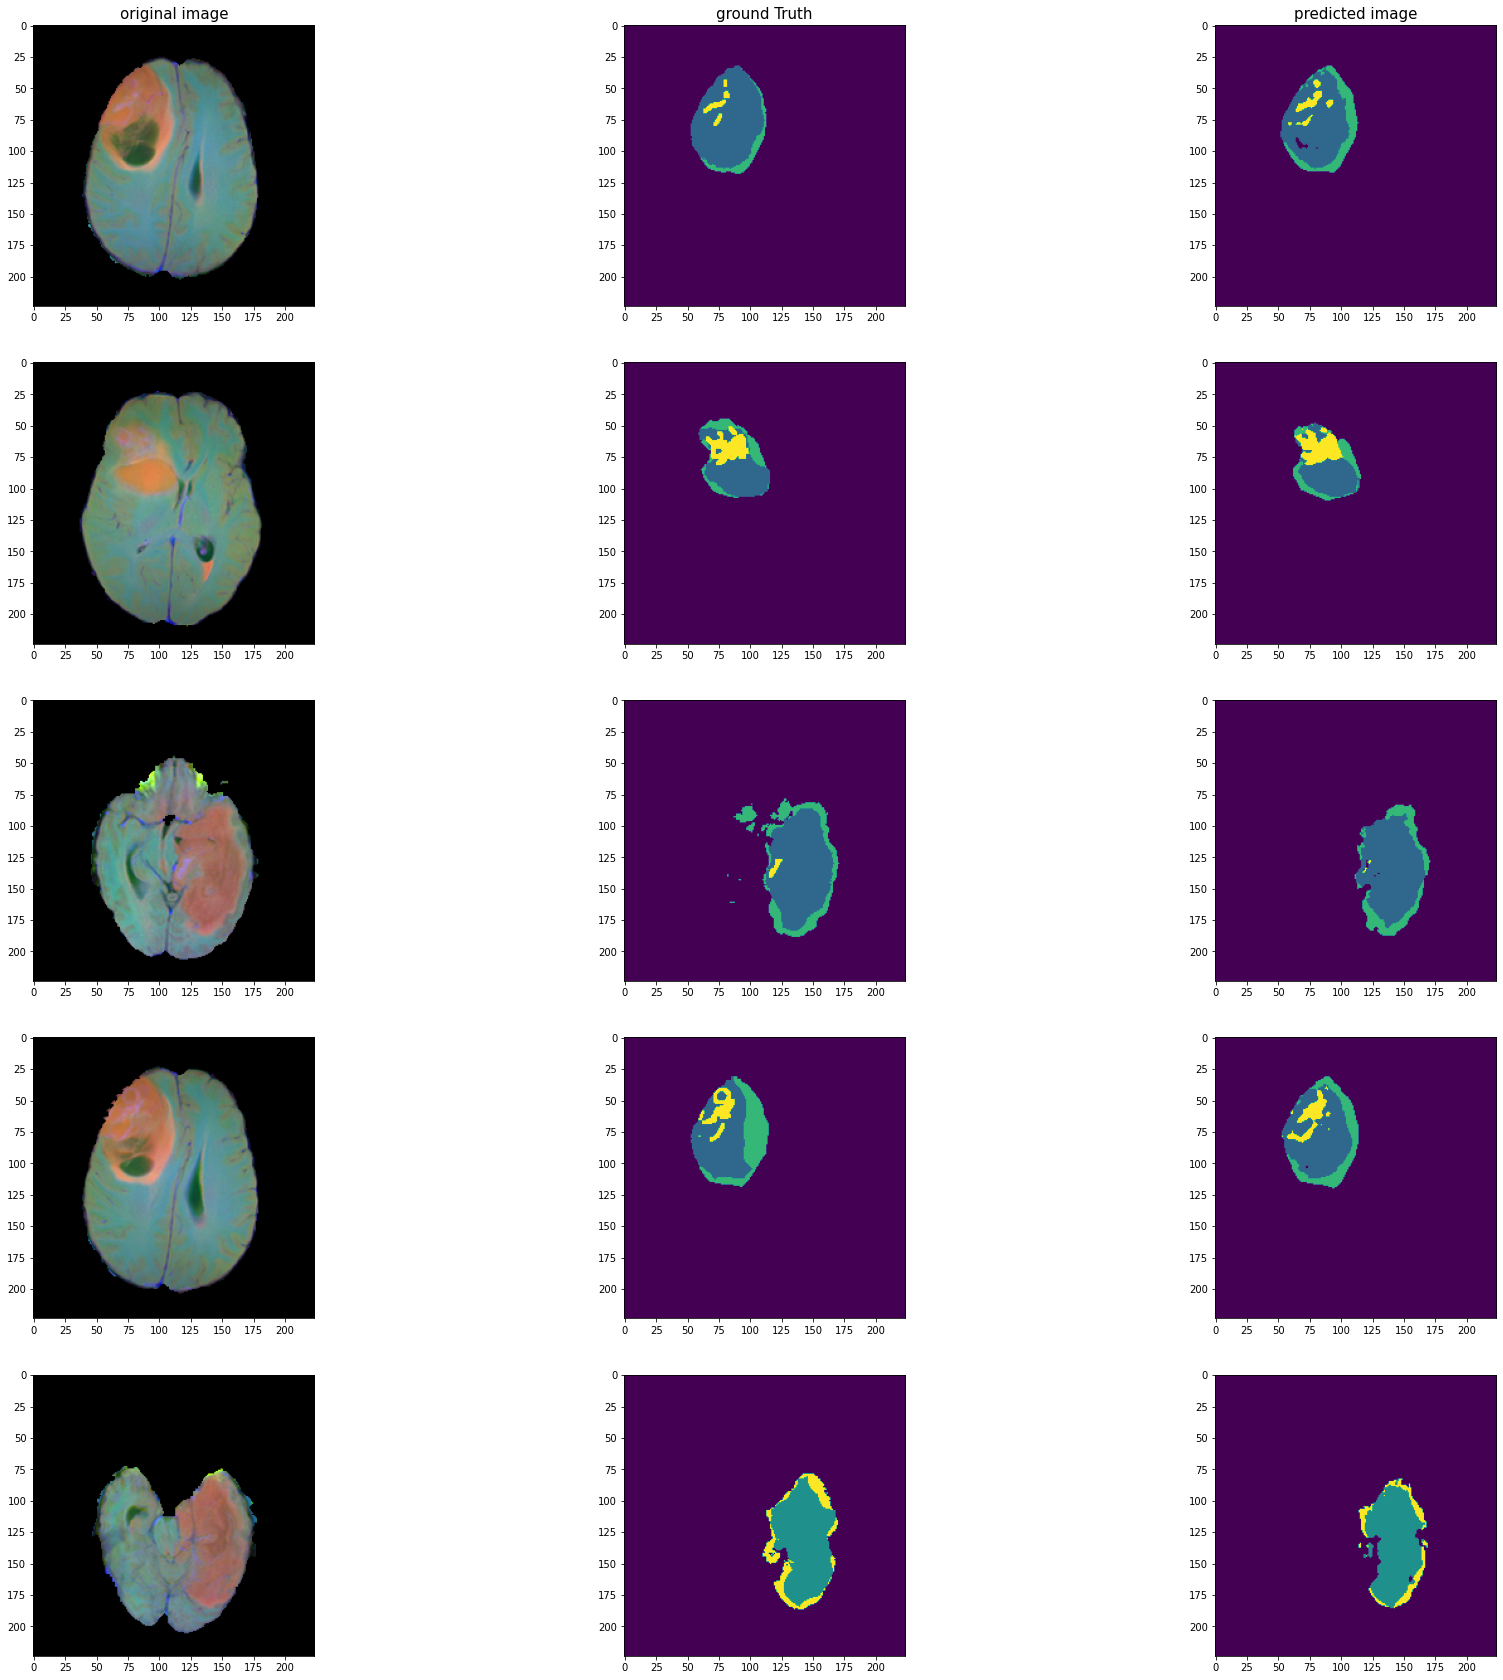

In [ ]:
#plot predictions
k=1
plt.figure(figsize=(30,30))
slice_no=[120,107,144,118,138]
for i in slice_no:
  image,groundtruth,pred_image=X[i],y[i],predictions[i]
  l=[image,np.argmax(groundtruth,axis=-1),np.argmax(pred_image,axis=-1)] #taken for a single modality
  for i in l:
    plt.subplot(5,3,k)
    plt.imshow(i)
    if(k==1):
      plt.title("original image",fontdict={"fontsize":15})
    if(k==2):
      plt.title("ground Truth",fontdict={"fontsize":15})
    if(k==3):
      plt.title("predicted image",fontdict={"fontsize":15})
      
    k=k+1